In [1]:
from pykrx import stock
import mpl_finance
import exchange_calendars as ecals


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import arrow
import pandas as pd
import numpy as np
import time

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model


/Users/minseop/.pyenv/versions/3.8.5/envs/env_stock_bot/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
# constant variables
TRAINING_DAYS = 1080
TRAINING_WINDOW = 50

# open, high, low, close, volume
NUM_FEATURE = 5

NUM_LAYER = 2
NUM_EPOCH = 100

In [3]:
def draw_candle_chart(df, title, postfix=''):
    DATE_TICK_RANGE = int(len(df)/9)
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    ax.set_title(title)

    date_index_list = range(len(df))
    date_list = []

    cnt = 0
    for day in df.index:
        date_list.append(arrow.get(day).format('YYYY-MM-DD')) if cnt % DATE_TICK_RANGE == 0 else date_list.append('')
        cnt = cnt + 1
    
    # to show first date and last date
    date_list[0] = arrow.get(df.index[0]).format('YYYY-MM-DD')
    date_list[len(date_list)-1-((cnt-1)%DATE_TICK_RANGE)] = ''
    date_list[len(date_list)-1] = arrow.get(df.index[len(df)-1]).format('YYYY-MM-DD')

    ax.xaxis.set_major_locator(ticker.FixedLocator(date_index_list))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(date_list))

    mpl_finance.candlestick2_ohlc(ax, df['open'+ postfix], df['high'+ postfix],
                                  df['low'+ postfix], df['close'+ postfix], width=0.5, colorup='r', colordown='b')
    plt.show()

In [4]:
def get_stock_info_dataframe(end_date, start_date, ticker):
    df = stock.get_market_ohlcv_by_date(fromdate=start_date, todate=end_date, ticker=ticker)
    df = df.rename(columns={
                      '시가': 'open',
                      '고가': 'high',
                      '저가': 'low',
                      '종가': 'close',
                      '거래량': 'volume'})

    return df

In [5]:
def split_training_and_test_dataframe(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(df)
    
    train_arr = scaled_df[0:int(len(scaled_df)*0.8),:]
    test_arr = scaled_df[int(len(scaled_df)*0.8):,:]
    
    return train_arr, test_arr, scaler


In [6]:
def gen_test_df(df):
    test_df = df.iloc[int(len(df)*0.8):,:]

    return test_df


In [7]:
def processing_training_data(train_arr, feature_idx):
    x_train, y_train = [], []
    
    for i in range(TRAINING_WINDOW, len(train_arr)):
        x_train.append(train_arr[i-TRAINING_WINDOW:i, feature_idx])
        y_train.append(train_arr[i, feature_idx])
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train

In [8]:
def training_model(x_train, y_train):
    start_time = time.time()
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=TRAINING_WINDOW, return_sequences=True, input_shape=(TRAINING_WINDOW, 1)))
    
    for i in range(NUM_LAYER):
        lstm_model.add(LSTM(units=TRAINING_WINDOW, return_sequences=True))
        lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(units=1))
    
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    lstm_model.fit(x_train, y_train, epochs=NUM_EPOCH, batch_size=20, verbose=False)
    print(f'training time: {time.time() - start_time} sec')
    
    return lstm_model



In [9]:
def predict_test_data(models, train_arr, test_arr, scaler):
    test_data = np.concatenate((train_arr[len(train_arr)-TRAINING_WINDOW:], test_arr ), axis=0)
    predicted_values = []

    for feature_idx in range(len(models)):
        x_test = []
        lstm_model = models[feature_idx]
        for i in range(TRAINING_WINDOW, len(test_data)):
            x_test.append(test_data[i-TRAINING_WINDOW:i,feature_idx])
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
        
        predicted_closing_price = lstm_model.predict(x_test)        
        predicted_values.append(predicted_closing_price)
        
    predicted_arr = predicted_values[0]
    
    for i in range(1, len(predicted_values)):
        predicted_arr = np.concatenate((predicted_arr, predicted_values[i]), axis=1)

    predicted_arr = scaler.inverse_transform(predicted_arr)
    
    return predicted_arr
    

        

In [10]:
def predict_next_open_day(models, test_arr, scaler):
    test_data = test_arr[len(test_arr)-TRAINING_WINDOW:]
    predicted_values = []

    for feature_idx in range(len(models)):
        x_test = []
        lstm_model = models[feature_idx]

        x_test.append(test_data[:,feature_idx])
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
        
        predicted_closing_price = lstm_model.predict(x_test)        
        predicted_values.append(predicted_closing_price)
        
    predicted_arr = predicted_values[0]
    
    for i in range(1, len(predicted_values)):
        predicted_arr = np.concatenate((predicted_arr, predicted_values[i]), axis=1)

    predicted_arr = scaler.inverse_transform(predicted_arr)
    
    return predicted_arr
    

        

In [11]:
def predict_share_price(stock_ticker: str):
    end_date = arrow.utcnow().shift(hours=9).format('YYYYMMDD')
    start_date = arrow.get(end_date).shift(days=-TRAINING_DAYS).format('YYYYMMDD')
    
    stock_name = stock.get_market_price_change_by_ticker(start_date, end_date).loc[stock_ticker, '종목명']

    df = get_stock_info_dataframe(end_date, start_date, stock_ticker)
    # draw_candle_chart(df, f'{ticker}: {start_date} ~ {end_date}')
    
    test_df = gen_test_df(df)
    train_arr, test_arr, scaler = split_training_and_test_dataframe(df)
    
    # training by feature
    models = []
    for feature_idx in range(0, NUM_FEATURE):
        x_train, y_train = processing_training_data(train_arr, feature_idx)
        try:
            model = load_model(f'share_price_prediction_feature_idx_{feature_idx}.h5')
        except Exception as e:
            model = training_model(x_train, y_train)
            model.save(f'share_price_prediction_feature_idx_{feature_idx}.h5')
        models.append(model)
        
    predicted_arr = predict_test_data(models, train_arr, test_arr, scaler)
    predicted_df = pd.DataFrame(predicted_arr, index=test_df.index, columns=test_df.columns)
    
    test_start_date = test_df.index[0]
    test_end_date = test_df.index[-1]
    
    draw_candle_chart(test_df, f'{stock_name}: {test_start_date} ~ {test_end_date}')
    draw_candle_chart(predicted_df, f'{stock_name}: {test_start_date} ~ {test_end_date}')
    
    
    xkrx = ecals.get_calendar('XKRX')
    next_date = arrow.get((xkrx.next_open(pd.Timestamp.today()))).format('YYYY-MM-DD')
    
    arr = predict_next_open_day(models, test_arr, scaler)
    next_date_open = arr[0][0]
    next_date_close = arr[0][3]
    
    last_date = arrow.get(test_end_date).format('YYYY-MM-DD')
    last_date_open = test_df.loc[last_date, 'open']
    last_date_close = test_df.loc[last_date, 'close']
    
    last_pred_date = arrow.get(test_end_date).format('YYYY-MM-DD')
    last_pred_date_open = predicted_df.loc[last_pred_date, 'open']
    last_pred_date_close = predicted_df.loc[last_pred_date, 'close']
    
    return [last_date, last_date_open, last_date_close,
            last_pred_date, last_pred_date_open, last_pred_date_close, 
            next_date, next_date_open, next_date_close]


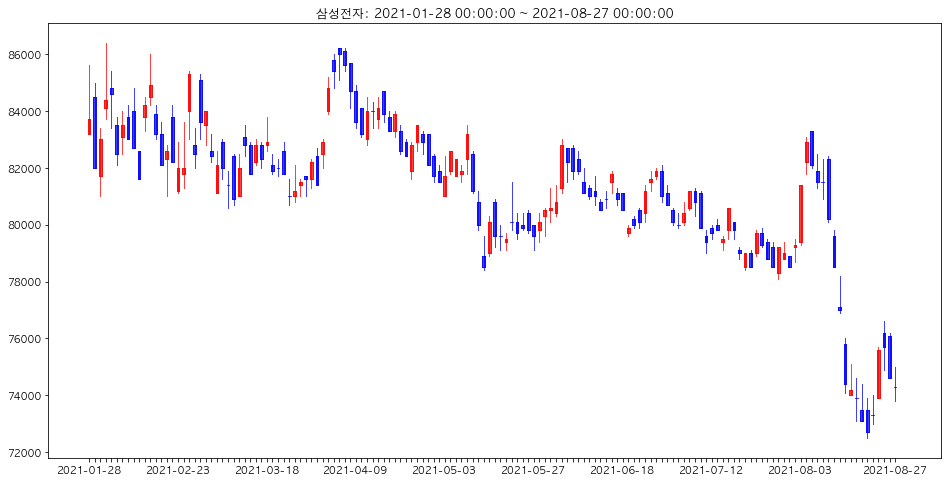

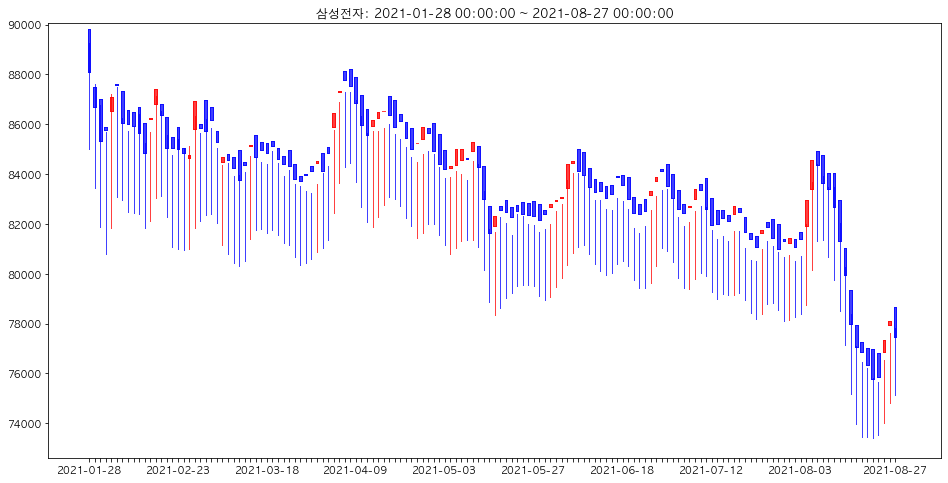

In [12]:
result = predict_share_price('005930')

In [13]:
last_date = result[0]
last_date_open = result[1]
last_date_close = result[2]
last_pred_date = result[3]
last_pred_date_open = result[4]
last_pred_date_close = result[5]
next_date = result[6]
next_date_open = result[7]
next_date_close = result[8] 

In [14]:
print(f'last day price      {last_date}: open: {last_date_open}, close: {last_date_close}')
print(f'last day prediction {last_pred_date}: open: {last_pred_date_open}, close: {last_pred_date_close}')
print(f'next day prediction {next_date}: open: {next_date_open}, close: {next_date_close}')

last day price      2021-08-27: open: 74300, close: 74300
last day prediction 2021-08-27: open: 78664.8984375, close: 77448.9296875
next day prediction 2021-08-30: open: 77883.5390625, close: 76693.359375


In [15]:
# feature 간 영향을 미치지만 현재 lstm 모델은 feature끼리 예측에 영향을 미치지 못함